### Import dependencies

In [117]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

import os
import sys
import time
import json
import copy

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import PIL
from PIL import Image
from collections import OrderedDict

import torch 
from torch import nn, optim 
from torch.optim import lr_scheduler 
from torch.autograd import Variable
import torchvision 
from torchvision import datasets, models, transforms 
# from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F

### Check GPU (in case you are not running this locally)

In [118]:
# CHECK IF GPU IS WORKING

train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:    
  print('Training on CPU ...')
else:    
  print('You are good to go!  Training on GPU ...')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Training on CPU ...


### Data Transformation

To make the the model more robust and flexible we should train it using images that are flipped, rotated, and cropped.

Here we will run a few transfromations on our dataset:

- we will use Torch's Torchvision.transform to do the transformations ([Documentation](https://pytorch.org/docs/stable/torchvision/transforms.html))

- we will use Torch's Torchvision.datasets.ImageFolder for our data loader ([Documentation](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder))

In [119]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(180),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

train_dir = "../content/train"
valid_dir = "../content/valid"

# Load the datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(train_dir if x == 'train' else valid_dir), data_transforms[x])
                  for x in ['train', 'valid']}

# Define the dataloaders, using the image datasets and the trainforms
batch_size = 32
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0)
               for x in ['train', 'valid']}

class_names = image_datasets['train'].classes
dataloaders_sizes = {x: len(dataloaders[x]) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}

In [120]:
print(dataset_sizes)
print(dataloaders_sizes)
print(class_names)

{'train': 194, 'valid': 36}
{'train': 7, 'valid': 2}
['darkskin', 'oliveskin', 'porcelainskin']


### Mapping the Data
we have to now map the data to the labels. The dataset comes with a JSON file that contains this mapping. We will just have to load it.

In [121]:
with open('../content/skin.json', 'r') as f:
    cat_to_name = json.load(f)
cat_to_name

{'0': 'dark skin', '2': 'porcelain skin', '1': 'olive skin'}

### Model Selection and Training

Model used:
[densenet161](https://www.kaggle.com/pytorch/densenet161)

In [122]:
# choose which model to use
model = models.densenet161(weights='IMAGENET1K_V1')
# deprecated version: model = models.densenet161(pretrained=True, weights='IMAGENET1K_V1')
num_in_features = 2208

In [123]:
# Create classifier
for param in model.parameters():
    param.requires_grad = False

def build_classifier(num_in_features, hidden_layers, num_out_features):
    classifier = nn.Sequential()
    if hidden_layers == None:
        classifier.add_module('fc0', nn.Linear(num_in_features, 3))
    else:
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        classifier.add_module('fc0', nn.Linear(num_in_features, hidden_layers[0]))
        classifier.add_module('relu0', nn.ReLU())
        classifier.add_module('drop0', nn.Dropout(.5))
        for i, (h1, h2) in enumerate(layer_sizes):
            classifier.add_module('fc'+str(i+1), nn.Linear(h1, h2))
            classifier.add_module('relu'+str(i+1), nn.ReLU())
            classifier.add_module('drop'+str(i+1), nn.Dropout(.5))
        classifier.add_module('output', nn.Linear(hidden_layers[-1], num_out_features))
    return classifier


In [124]:
hidden_layers = None

classifier = build_classifier(num_in_features, hidden_layers, 3)
print(classifier)

# Only train the classifier parameters, feature parameters are frozen
model.classifier = classifier
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
sched = optim.lr_scheduler.StepLR(optimizer, step_size=4)

Sequential(
  (fc0): Linear(in_features=2208, out_features=3, bias=True)
)


In [125]:
def plot_loss_and_accuracy(train_losses, valid_losses, train_accs, valid_accs, num_epochs):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(1, num_epochs + 1), train_losses, label='Train')
    plt.plot(np.arange(1, num_epochs + 1), valid_losses, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(1, num_epochs + 1), train_accs, label='Train')
    plt.plot(np.arange(1, num_epochs + 1), valid_accs, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [126]:
# Adapted from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def train_model(model, criterion, optimizer, sched, num_epochs=5):
    """
        Train model for a given number of epochs,
        print loss and accuracy for each epoch.
    """
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward propagate + optimize only if in training phase
                    if phase == 'train':
                        #sched.step()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc)
            else:
                valid_losses.append(epoch_loss)
                valid_accs.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    #load best model weights
    model.load_state_dict(best_model_wts)

    # Visualize training and validation metrics(accuracy and loss)
    plot_loss_and_accuracy(train_losses, valid_losses, train_accs, valid_accs, num_epochs)
    
    return model

Epoch 1/20
----------
train Loss: 1.1665 Acc: 0.4278
valid Loss: 1.0950 Acc: 0.3333

Epoch 2/20
----------
train Loss: 0.9586 Acc: 0.5619
valid Loss: 1.0024 Acc: 0.5278

Epoch 3/20
----------
train Loss: 0.8655 Acc: 0.5928
valid Loss: 0.9312 Acc: 0.7500

Epoch 4/20
----------
train Loss: 0.8143 Acc: 0.6082
valid Loss: 0.9353 Acc: 0.6111

Epoch 5/20
----------
train Loss: 0.7728 Acc: 0.6907
valid Loss: 0.8944 Acc: 0.5556

Epoch 6/20
----------
train Loss: 0.7030 Acc: 0.7010
valid Loss: 0.7843 Acc: 0.7500

Epoch 7/20
----------
train Loss: 0.6539 Acc: 0.7680
valid Loss: 0.7840 Acc: 0.7500

Epoch 8/20
----------
train Loss: 0.6268 Acc: 0.7990
valid Loss: 0.7464 Acc: 0.7500

Epoch 9/20
----------
train Loss: 0.6063 Acc: 0.7680
valid Loss: 0.7322 Acc: 0.7222

Epoch 10/20
----------
train Loss: 0.5876 Acc: 0.8299
valid Loss: 0.8045 Acc: 0.7222

Epoch 11/20
----------
train Loss: 0.6152 Acc: 0.8402
valid Loss: 0.7090 Acc: 0.8056

Epoch 12/20
----------
train Loss: 0.5342 Acc: 0.8247
valid Los

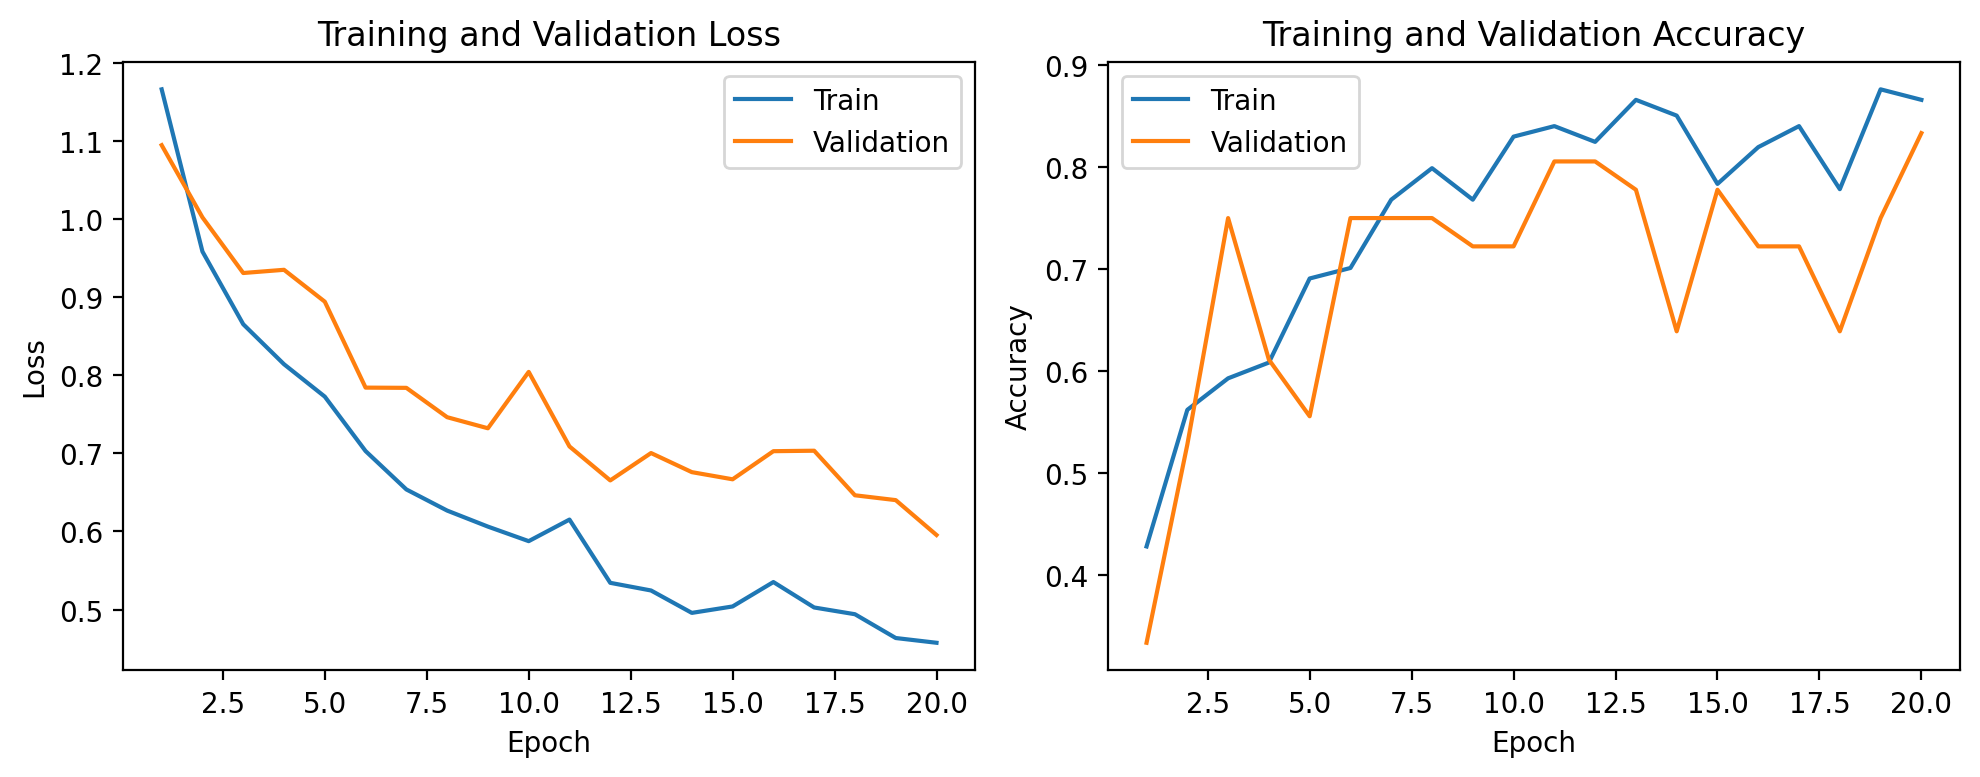

In [127]:
epochs = 20
model.to(device)
model = train_model(model, criterion, optimizer, sched, epochs)

### Evaluate the model's performance using other metrics.

- ##### Accuracy

In [128]:
# Model Evaluation

model.eval()

accuracy = 0

for inputs, labels in dataloaders['valid']:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    
    # Class with the highest probability is our predicted class
    equality = (labels.data == outputs.max(1)[1])

    # Accuracy is number of correct predictions divided by all predictions
    accuracy += equality.type_as(torch.FloatTensor()).mean()
    
print("Test accuracy: {:.3f}".format(accuracy/len(dataloaders['valid'])))

Test accuracy: 0.906


- ##### f1_score, precision_score, and recall_score

In [129]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

model.eval()

predicted_labels = []
true_labels = []

for inputs, labels in dataloaders['valid']:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)

    _, preds = torch.max(outputs, 1)

    predicted_labels.extend(preds.cpu().numpy())
    true_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels)

# Calculate evaluation metrics
# accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average='weighted')
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')

# Print evaluation metrics
print("F1 score: {:.3f}".format(f1))
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))

# Plot accuracy and loss curves
# plt.plot(training_losses, label='Training Loss')
# plt.plot(validation_losses, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()


F1 score: 0.836
Precision: 0.847
Recall: 0.833


Confusion Matrix:
[[12  0  2]
 [ 2  9  0]
 [ 2  0  9]]


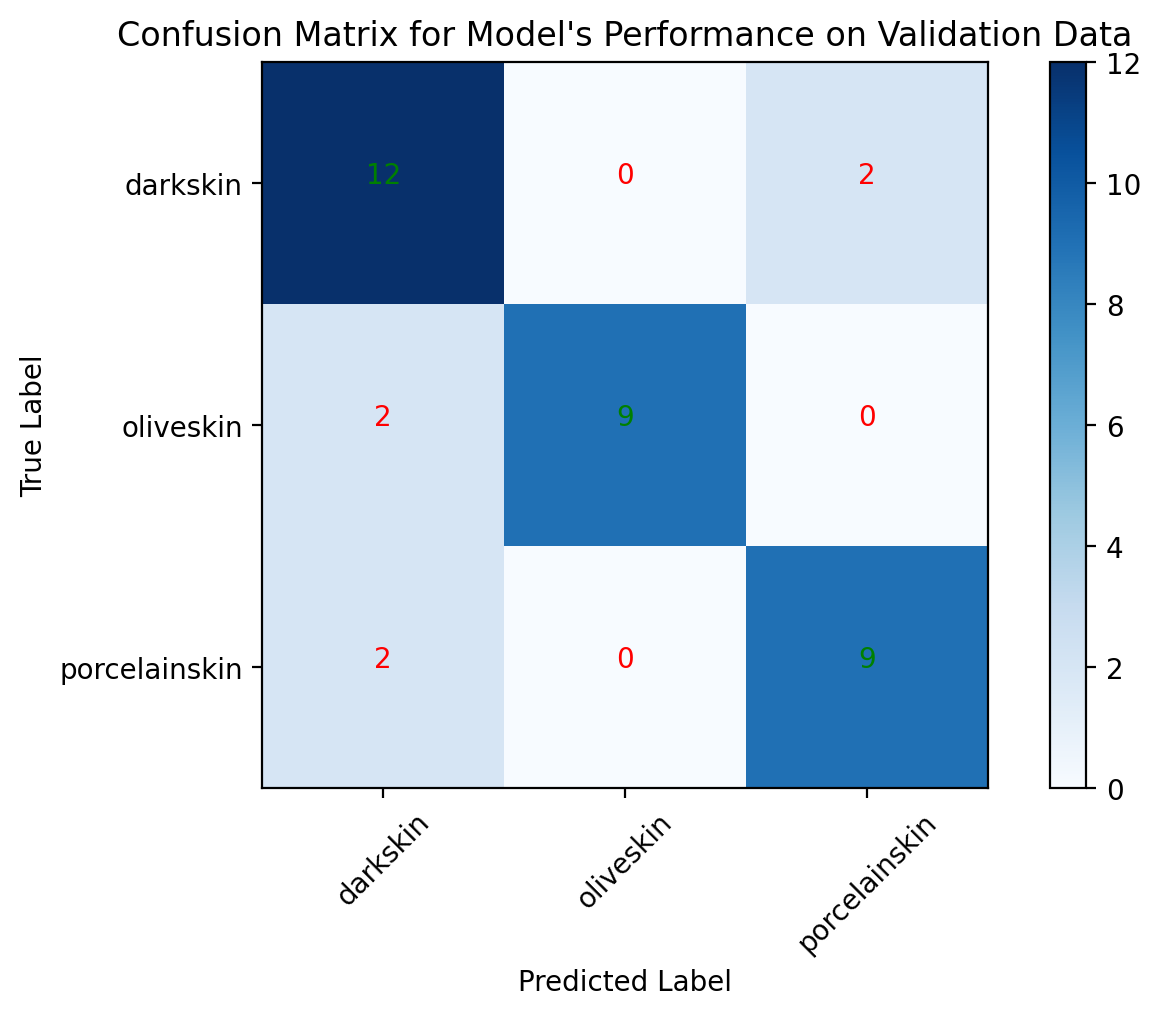

In [130]:
# Calculate the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix:")
print(confusion)

# Define class labels
class_labels = class_names

# Plot the confusion matrix
plt.figure(figsize=(7, 5))
plt.imshow(confusion, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Model\'s Performance on Validation Data')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

# Normalize the confusion matrix
normalized_confusion = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]

# Add text annotations
thresh = normalized_confusion.max() / 2.0
for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        plt.text(j, i, "{:,}".format(confusion[i, j]),
                 horizontalalignment="center",
                 color="green" if normalized_confusion[i, j] > thresh else "red")

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


### Save the checkpoint of the trained model

In [132]:
# Map image classes to model classes
model.class_to_idx = image_datasets['train'].class_to_idx
model.class_to_idx

{'darkskin': 0, 'oliveskin': 1, 'porcelainskin': 2}

In [133]:
# create and save checkpoints
checkpoint = {'input_size': 2208,
              'output_size': 3,
              'epochs': epochs,
              'batch_size': 64,
              'model': models.densenet161(pretrained=True),
              'classifier': classifier,
              'scheduler': sched,
              'optimizer': optimizer.state_dict(),
              'state_dict': model.state_dict(),
              'class_to_idx': model.class_to_idx
             }
   
# torch.save(checkpoint, '../models/Skintone-Model/final_model.pth')
torch.save(checkpoint, '../new_model_02_06.pth')

### Load and use model for image classification and prediction

In [134]:
def load_checkpoint(filepath):
    """Load pre-trained model from the checkpoint."""
    checkpoint = torch.load(filepath, map_location=torch.device('cpu'))
    # checkpoint['input_size'] = 25088
    model = checkpoint['model']
    model.classifier = checkpoint['classifier']
    model.load_state_dict = (checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    optimizer = checkpoint['optimizer']
    epochs = checkpoint['epochs']

    for param in model.parameters():
        param.requires_grad = False

    return model, checkpoint['class_to_idx']


In [135]:
#model, class_to_idx = load_checkpoint('./models/checkpoint_ic_d161.pth')
model, class_to_idx = load_checkpoint('../new_model_02_06.pth')
class_to_idx

{'darkskin': 0, 'oliveskin': 1, 'porcelainskin': 2}

In [136]:
def process_image(image):
    ''' Scale, crop, and normalize a PIL image for a PyTorch model,
        return an Numpy array.
    '''
    # Convert image to RGB mode
    image = image.convert("RGB")
    
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225])
    ])
    image = preprocess(image)
    return image


def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax


In [137]:
import numpy as np
import torch

def tensor_to_image(tensor):
    """Convert the tensor output from 'process_image' to a numpy array."""
    tensor = tensor.cpu().detach().numpy()
    
    # Scale the values to [0, 255]
    tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())
    tensor = 255 * tensor
    
    # Convert the numpy array to an image array
    image_array = tensor.transpose((1, 2, 0)).astype(np.uint8)
    
    return image_array


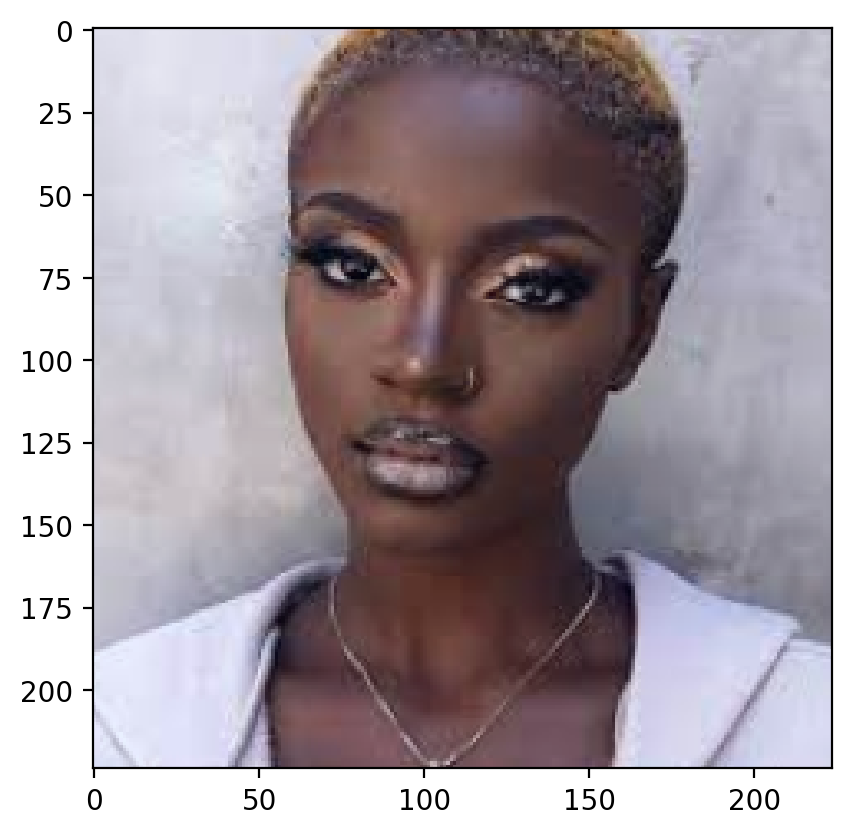

In [138]:
# Testing imshow function
with Image.open('../content/valid/darkskin/images.jpg') as image:
    processed_image = process_image(image)
    pil_image = tensor_to_image(processed_image)
    plt.imshow(pil_image)


In [139]:
def predict2(image_path, model, topk=3):
    ''' Predict the class (or classes) of an image using a trained deep learning model.'''

    img = Image.open(image_path)
    img = process_image(img)
    
    # Convert 2D image to 1D vectorcle
    img = np.expand_dims(img, 0)
    img = torch.from_numpy(img)

    model.eval()
    inputs = Variable(img).to(device)
    # model.classifier[0] = nn.Linear(2208, 120, bias = True)

    logits = model.forward(inputs)

    ps = F.softmax(logits, dim=1)
    topk = ps.cpu().topk(topk)

    return (e.data.numpy().squeeze().tolist() for e in topk)



In [140]:
import plotly.graph_objects as go
import pandas as pd

# load the makeup dataset
rec = pd.read_csv('../content/makeup.csv')

def view_classify(img_path, prob, classes, cat_to_name, rec):
    ''' 
        Function for viewing an image, probability of it belonging to the classes.
        Also display recommended products based on class with highest probability
    '''
    image = Image.open(img_path)

    # Show the image being classified
    fig, (ax1, ax2) = plt.subplots(figsize=(13, 5), ncols=2)
    ax1.set_title('Uploaded Image')
    ax1.imshow(image)
    ax1.axis('off')
    print(f"Classes: {classes}")

    classes_dict = {0: "Dark skin", 1: "Olive skin", 2: "Porcelain skin"}
    # Show the prediction probability outputted by model for the image
    y_pos = np.arange(len(prob))
    ax2.barh(y_pos, prob, align='center')
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([classes_dict[i] for i in classes])
    ax2.invert_yaxis()  # labels read top-to-bottom
    ax2.set_title('Skintone Class Probability')

    # Set spacing between subplots
    plt.subplots_adjust(wspace=0.5)
    plt.show()

    # Select products equivalent to skintone of uploaded image
    skintype = cat_to_name[str(classes[0])]
    rec1 = rec.loc[rec['SkinTone'] == skintype][:3]

    # Display recommended products based on the model's predictions in tabular format
    fig = go.Figure(data=[go.Table(
    header=dict(values=list(rec1.columns),
               fill_color='paleturquoise',
               align='left'),
    cells=dict(values=[rec1.Label, rec1.Brand, rec1.ProductName,rec1.HEXColor, rec1.SkinTone, rec1.ProductURL, rec1.Price, rec1.SkinType],
              fill_color='lavender',
              align='left'))
      ])
    fig.update_layout(
        title={
            'text': "Product Recommendations",
            'y': 0.95,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        }
    )
    fig.show()
    # print(rec1.to_dict())

    def make_clickable(val):
        # target _blank to open new window
        return '<a href="{}" target="_blank">{}</a>'.format(val, val)

    rec1['ProductURL'] = rec1['ProductURL'].apply(make_clickable)
    # rec1.style.format({'ProductURL': make_clickable})

    return (rec1)


Classes: [2, 1, 0]


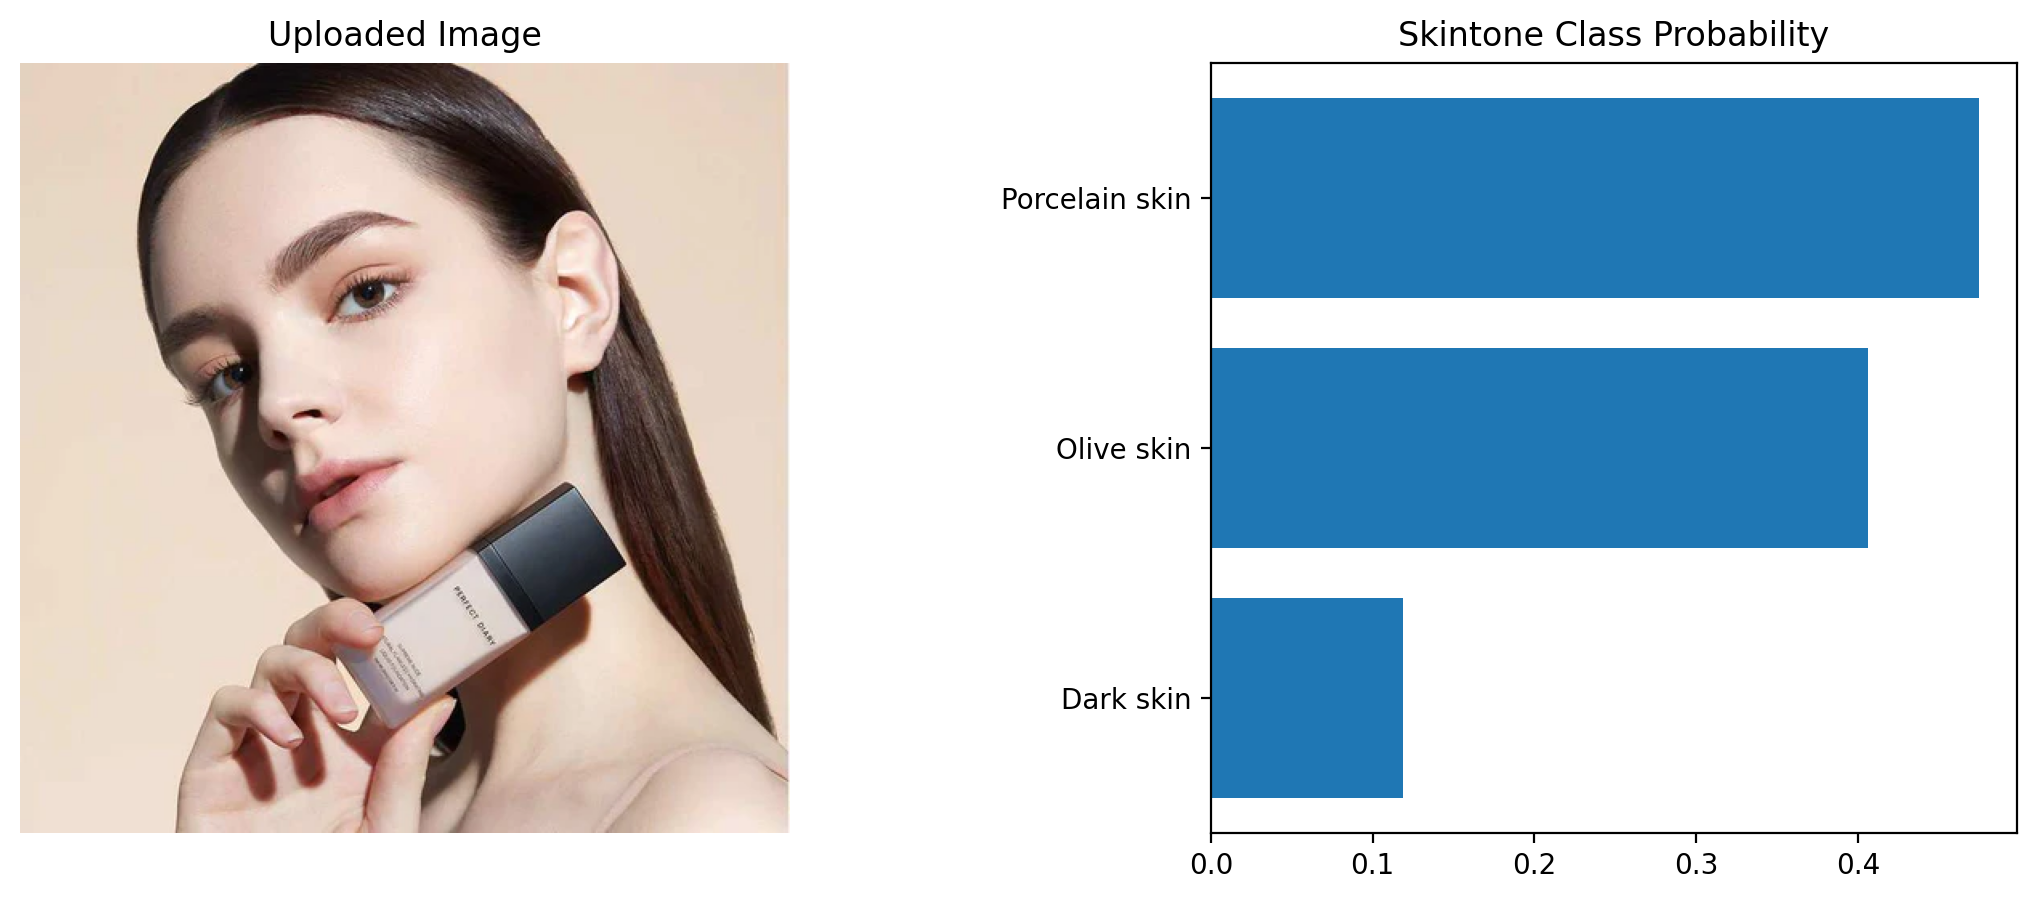

In [141]:
file = '../content/valid/porcelainskin/images.jpg'
probs, classes = predict2(file, model.to(device))
text = (view_classify(file, probs, classes, cat_to_name, rec))

Classes: [0, 1, 2]


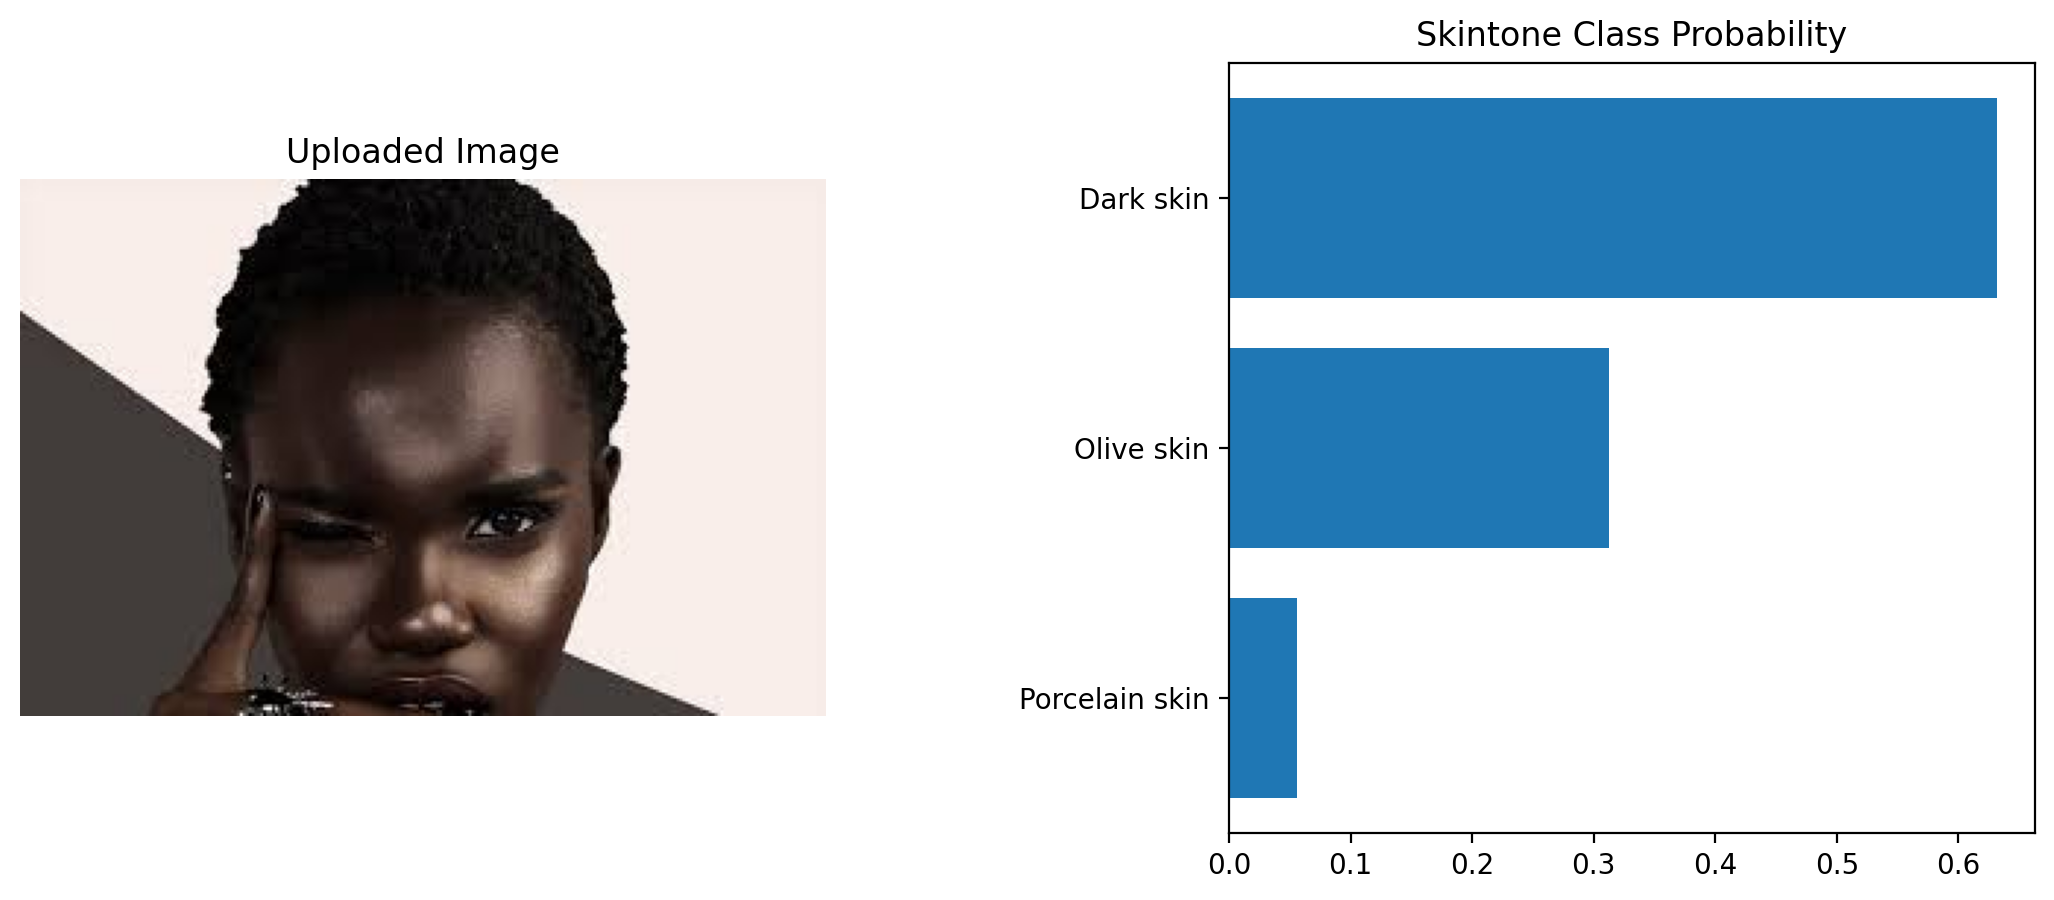

[0.6313696503639221, 0.31258946657180786, 0.05604090541601181]
[0, 1, 2]


In [142]:
# file = '../content/trial_images/testD1.jpg'
file = '../content/train/darkskin/black14.jpg'
probs, classes = predict2(file, model.to(device))
text = (view_classify(file, probs, classes, cat_to_name, rec))
print(probs)
print(classes)

Classes: [2, 1, 0]


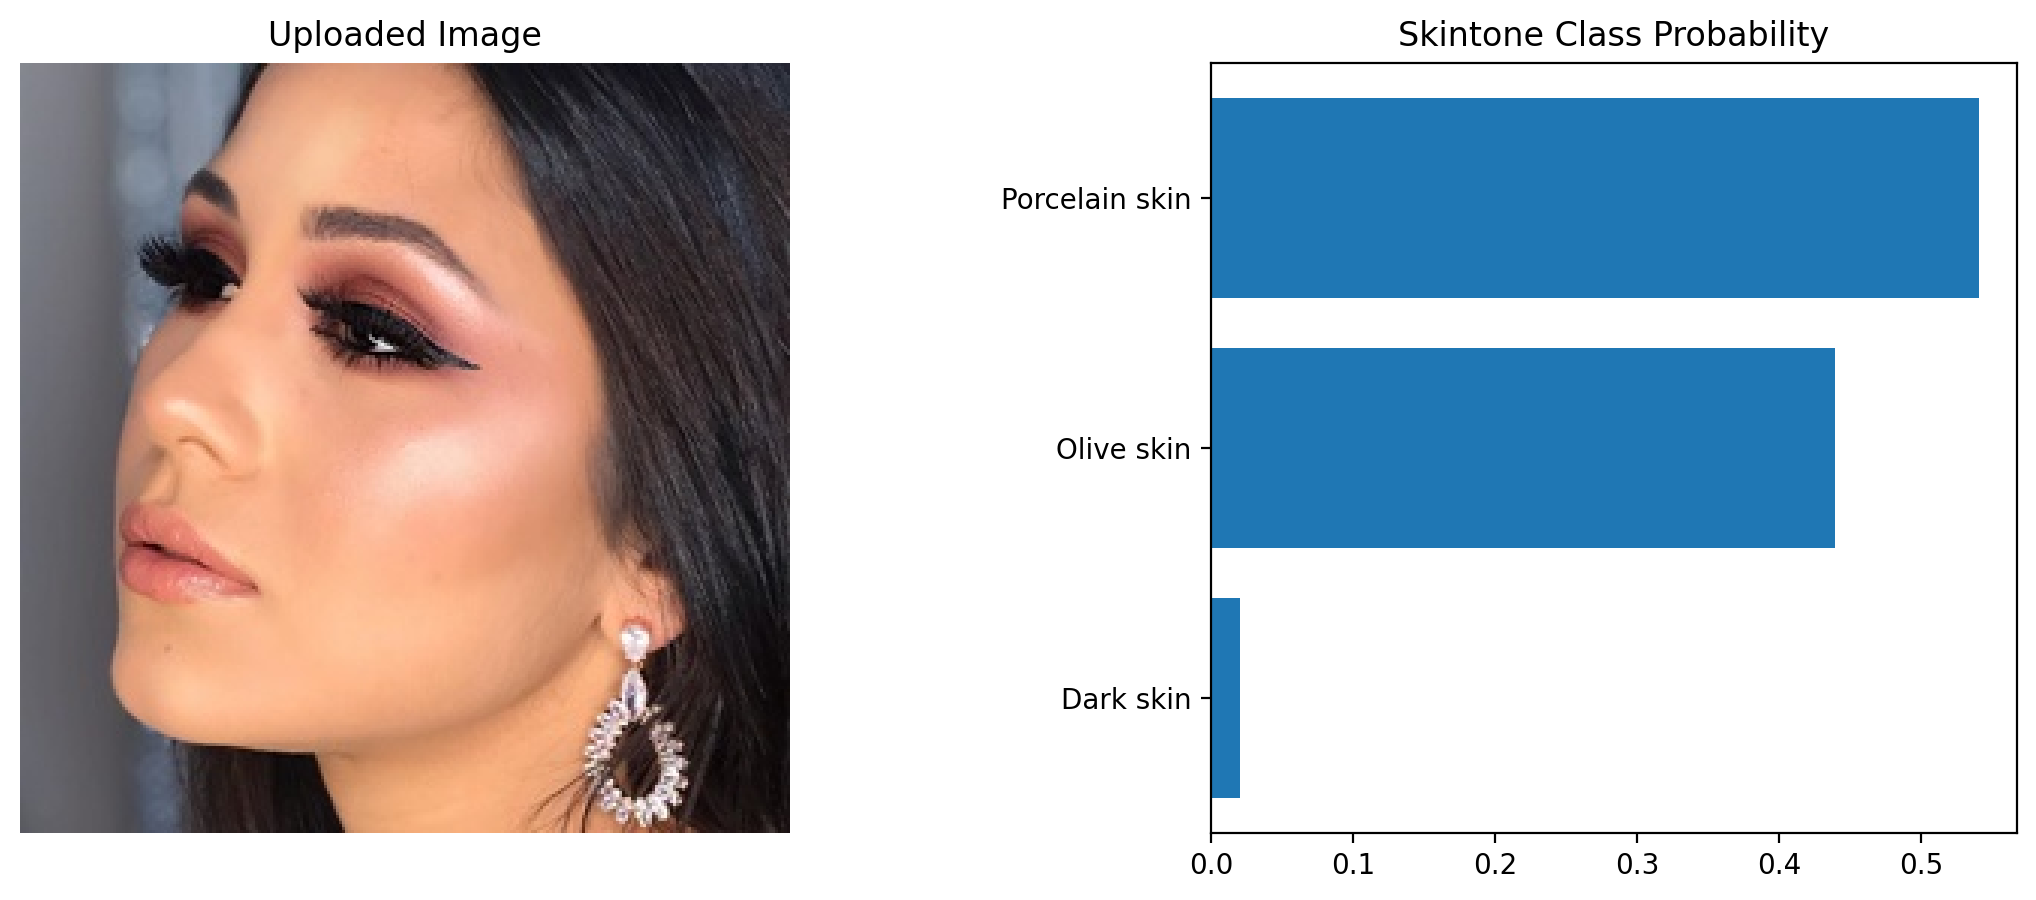

[0.5402027368545532, 0.439344584941864, 0.020452702417969704]
[2, 1, 0]


In [143]:
file = '../content/trial_images/testO1.jpg'
probs, classes = predict2(file, model.to(device))
text = (view_classify(file, probs, classes, cat_to_name, rec))

print(probs)
print(classes)